In [56]:
import pandas as pd 
from pandas import DataFrame, read_csv
import os
import csv 
import numpy as np 
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [3]:
data_train = []
target_train = []

for filename in os.listdir('/Users/zhl/Documents/1011/aclImdb/train/pos'):
    data = open('/Users/zhl/Documents/1011/aclImdb/train/pos/' + filename, 'r' , encoding="ISO-8859-1").read()
    #data = remove_stopwords(data, stopwords)
    data_train.append(data)
    target_train.append("1")
    
for filename in os.listdir('/Users/zhl/Documents/1011/aclImdb/train/neg'):
    data = open('/Users/zhl/Documents/1011/aclImdb/train/neg/' + filename, 'r' , encoding="ISO-8859-1").read()
    #data = remove_stopwords(data, stopwords)
    data_train.append(data)
    target_train.append("0")


In [4]:
import random

# c = list(zip(data_train, target_train))

# random.shuffle(c)

# a, b = zip(*c)

# data_train = list(a)
# target_train = list(b)

train_split = 10000
train_data = data_train[:train_split] + data_train[-train_split:]
train_targets = target_train[:train_split] + target_train[-train_split:]

val_data = data_train[train_split:-train_split]
val_targets = target_train[train_split:-train_split]

train_targets = np.array(train_targets).astype(int)
val_targets = np.array(val_targets).astype(int)

In [5]:
test_data = []
test_targets = []

for filename in os.listdir('/Users/zhl/Documents/1011/aclImdb/test/pos'):
    data = open('/Users/zhl/Documents/1011/aclImdb/test/pos/' + filename, 'r' , encoding="ISO-8859-1").read()
    #data = remove_stopwords(data, stopwords)
    test_data.append(data)
    test_targets.append("1")
    
for filename in os.listdir('/Users/zhl/Documents/1011/aclImdb/test/neg'):
    data = open('/Users/zhl/Documents/1011/aclImdb/test/neg/' + filename, 'r' , encoding="ISO-8859-1").read()
    #data = remove_stopwords(data, stopwords)
    test_data.append(data)
    test_targets.append("0")

test_targets = np.array(test_targets).astype(int)

In [6]:
print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [7]:
#Clean the text
def clean_text(text_list):
    text_clean = [text.replace('[^\w\s]','') for text in text_list]
    text_clean = [text.replace('<br />', ' ') for text in text_clean]
    text_clean = [re.sub(r"([\.\",\(\)!\?;:-])", "", text) for text in text_clean]
    return text_clean

In [8]:
train_data = clean_text(train_data)
val_data = clean_text(val_data)
test_data = clean_text(test_data)

In [9]:
#Remove stop word
stop = stopwords.words('english')

In [10]:
import spacy
import string

tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

In [11]:
import pickle as pkl

def tokenize_dataset(dataset):
    token_dataset = []
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data)
pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data)
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [15]:
from collections import Counter

#max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, 10000)

In [16]:
# Lets check the dictionary by loading random token from it
import random
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 3194 ; token redemption
Token redemption; token id 3194


In [17]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


Pytorch dataloader

In [42]:
MAX_SENTENCE_LENGTH = 10000

import numpy as np
import torch
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def IMDB_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = IMDBDataset(train_data_indices, train_targets)
#val_loader = IMDBDataset(val_data_indices, val_targets)
#test_loader = IMDBDataset(test_data_indices, test_targets)

BATCH_SIZE = 100
train_dataset = IMDBDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)

val_dataset = IMDBDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)

test_dataset = IMDBDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)



for i, (data, lengths, labels) in enumerate(train_loader):
    print (data)
    print (labels)
    break

tensor([[   1, 4835,    2,  ...,    0,    0,    0],
        [ 677, 3756,   13,  ...,    0,    0,    0],
        [ 458,  109,    1,  ...,    0,    0,    0],
        ...,
        [  10, 2362,    6,  ...,    0,    0,    0],
        [  11, 8374, 2981,  ...,    0,    0,    0],
        [  11,  160,    7,  ...,    0,    0,    0]])
tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1])


Bag-of-Words

In [43]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [44]:
learning_rate = 0.01
num_epochs = 3 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader))

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

val_acc_list =[]
loss_list = []


for epoch in range(num_epochs):
    #scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_list.append(loss)
        loss.backward()
        optimizer.step()
        
        # validate every 100 iterations
        if i > 0 and i % 50 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_list.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    
    

Epoch: [1/3], Step: [51/200], Validation Acc: 76.74
Epoch: [1/3], Step: [101/200], Validation Acc: 84.1
Epoch: [1/3], Step: [151/200], Validation Acc: 88.1
Epoch: [2/3], Step: [51/200], Validation Acc: 88.82
Epoch: [2/3], Step: [101/200], Validation Acc: 89.72
Epoch: [2/3], Step: [151/200], Validation Acc: 89.78
Epoch: [3/3], Step: [51/200], Validation Acc: 88.72
Epoch: [3/3], Step: [101/200], Validation Acc: 89.72
Epoch: [3/3], Step: [151/200], Validation Acc: 89.7


In [45]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 3 epochs
Val Acc 89.94
Test Acc 87.8


In [46]:
print(max(val_acc_list))

89.78


In [163]:
print(max(val_acc_list_100), max(val_acc_list_200), max(val_acc_list_300))

89.66 89.52 89.6


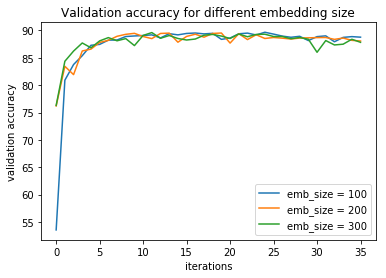

In [152]:
import matplotlib.pyplot as plt

plt.plot(val_acc_list_100, label = 'emb_size = 100')
plt.plot(val_acc_list_200, label = 'emb_size = 200')
plt.plot(val_acc_list_300, label = 'emb_size = 300')

plt.xlabel('iterations')
plt.ylabel('validation accuracy')
plt.title('Validation accuracy for different embedding size')
plt.legend()
plt.show()

In [157]:
loss_list_100 = [float(x) for x in loss_list_100]
loss_list_200 = [float(x) for x in loss_list_200]
loss_list_300 = [float(x) for x in loss_list_300]

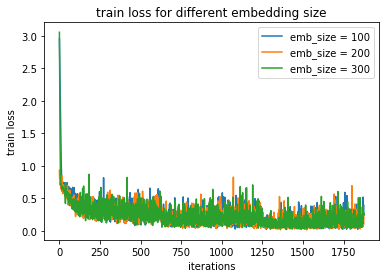

In [158]:
plt.plot(loss_list_100, label = 'emb_size = 100')
plt.plot(loss_list_200, label = 'emb_size = 200')
plt.plot(loss_list_300, label = 'emb_size = 300')

plt.xlabel('iterations')
plt.ylabel('train loss')
plt.title('train loss for different embedding size')
plt.legend()
plt.show()

# n-gram models

In [20]:
def tokenize_dataset_ngram(dataset, n = 1):
    token_dataset = []
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        n_gram_tokens = []
        for i in range(len(tokens) - n + 1):
            n_gram_tokens.append(' '.join(tokens[i:i + n]))
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [21]:
#tokenize bi-gram
# val set tokens
print ("Tokenizing val data")
val_data_2gram, _ = tokenize_dataset_ngram(val_data, n = 2)
pkl.dump(val_data_2gram, open("val_data_2gram.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_2gram, _ = tokenize_dataset_ngram(test_data, n = 2)
pkl.dump(test_data_2gram, open("test_data_2gram.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_2gram, train_data_2 = tokenize_dataset_ngram(train_data, n = 2)
pkl.dump(train_data_2gram, open("train_data_2gram.p", "wb"))
pkl.dump(train_data_2, open("train_data_2.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [22]:
#tokenize tri-gram
# val set tokens
print ("Tokenizing val data")
val_data_3gram, _ = tokenize_dataset_ngram(val_data, n = 3)
pkl.dump(val_data_3gram, open("val_data_3gram.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_3gram, _ = tokenize_dataset_ngram(test_data, n = 3)
pkl.dump(test_data_3gram, open("test_data_3gram.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_3gram, train_data_3 = tokenize_dataset_ngram(train_data, n = 3)
pkl.dump(train_data_3gram, open("train_data_3gram.p", "wb"))
pkl.dump(train_data_3, open("train_data_3.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [23]:
#tokenize four-gram
# val set tokens
print ("Tokenizing val data")
val_data_4gram, _ = tokenize_dataset_ngram(val_data, n = 4)
pkl.dump(val_data_4gram, open("val_data_2gram.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_4gram, _ = tokenize_dataset_ngram(test_data, n = 4)
pkl.dump(test_data_4gram, open("test_data_4gram.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_4gram, train_data_4 = tokenize_dataset_ngram(train_data, n = 4)
pkl.dump(train_data_4gram, open("train_data_4gram.p", "wb"))
pkl.dump(train_data_4, open("train_data_4.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [31]:
token2id, id2token = build_vocab(all_train_tokens, 10000)
#check the dictionary
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]
print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))
    
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
    
# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
    
BATCH_SIZE = 32
train_dataset = IMDBDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)

val_dataset = IMDBDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)

test_dataset = IMDBDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)
    
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 3 # number epoch to train
    
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_1 = []
val_acc_list_1 = []

for epoch in range(num_epochs):
#scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_list_1.append(loss)
        loss.backward()
        optimizer.step()
        
        # validate every 100 iterations
        if i > 0 and i % 50 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            val_acc_list_1.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    


Token id 7484 ; token sitcoms
Token sitcoms; token id 7484
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch: [1/3], Step: [51/625], Validation Acc: 54.28
Epoch: [1/3], Step: [101/625], Validation Acc: 81.28
Epoch: [1/3], Step: [151/625], Validation Acc: 78.36
Epoch: [1/3], Step: [201/625], Validation Acc: 85.88
Epoch: [1/3], Step: [251/625], Validation Acc: 86.0
Epoch: [1/3], Step: [301/625], Validation Acc: 87.96
Epoch: [1/3], Step: [351/625], Validation Acc: 88.54
Epoch: [1/3], Step: [401/625], Validation Acc: 87.66
Epoch: [1/3], Step: [451/625], Validation Acc: 88.06
Epoch: [1/3], Step: [501/625], Validation Acc: 88.82
Epoch: [1/3], Step: [551/625], Validation Acc: 88.5
Epoch: [1/3], Step: [601/625], Validation Acc: 89.5
Epoch: [2/3], Step: [51/625], Validation Acc: 88.56
Epoch: [2/3], Step: [101/625], Validation Acc: 89.32
Epoch: [2/3], Step: [151/625], Validation Acc: 89.42
Epoch: [2/3], Step: [201/625], Validation Acc: 89.18
Epoch: [2/3], Step

In [32]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 3 epochs
Val Acc 88.06
Test Acc 85.9


In [52]:
token2id, id2token = build_vocab(train_data_2, 10000)
#check the dictionary
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]
print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))
    
train_data_indices = token2index_dataset(train_data_2gram)
val_data_indices = token2index_dataset(val_data_2gram)
test_data_indices = token2index_dataset(test_data_2gram)
    
# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
    
BATCH_SIZE = 32
train_dataset = IMDBDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)

val_dataset = IMDBDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)

test_dataset = IMDBDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)
    
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 3 # number epoch to train
    
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_2 = []
val_acc_list_2 = []

for epoch in range(num_epochs):
#scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_list_2.append(loss)
        loss.backward()
        optimizer.step()
        
    # validate every 100 iterations
        if i > 0 and i % 50 == 0:
        # validate
            val_acc = test_model(val_loader, model)
            val_acc_list_2.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    




Token id 8346 ; token reject
Token reject; token id 8346
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch: [1/3], Step: [51/625], Validation Acc: 67.3
Epoch: [1/3], Step: [101/625], Validation Acc: 74.82
Epoch: [1/3], Step: [151/625], Validation Acc: 85.04
Epoch: [1/3], Step: [201/625], Validation Acc: 86.36
Epoch: [1/3], Step: [251/625], Validation Acc: 86.86
Epoch: [1/3], Step: [301/625], Validation Acc: 87.88
Epoch: [1/3], Step: [351/625], Validation Acc: 88.16
Epoch: [1/3], Step: [401/625], Validation Acc: 87.3
Epoch: [1/3], Step: [451/625], Validation Acc: 88.08
Epoch: [1/3], Step: [501/625], Validation Acc: 88.76
Epoch: [1/3], Step: [551/625], Validation Acc: 89.0
Epoch: [1/3], Step: [601/625], Validation Acc: 89.42
Epoch: [2/3], Step: [51/625], Validation Acc: 89.66
Epoch: [2/3], Step: [101/625], Validation Acc: 89.72
Epoch: [2/3], Step: [151/625], Validation Acc: 89.24
Epoch: [2/3], Step: [201/625], Validation Acc: 88.78
Epoch: [2/3], Step: 

In [53]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 3 epochs
Val Acc 89.08
Test Acc 86.516


In [37]:
token2id, id2token = build_vocab(train_data_3, 10000)
#check the dictionary
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]
print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))
    
train_data_indices = token2index_dataset(train_data_3gram)
val_data_indices = token2index_dataset(val_data_3gram)
test_data_indices = token2index_dataset(test_data_3gram)
    
# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
    
BATCH_SIZE = 32
train_dataset = IMDBDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)

val_dataset = IMDBDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)

test_dataset = IMDBDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)
    
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 3 # number epoch to train
    
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_3 = []
val_acc_list_3 = []

for epoch in range(num_epochs):
#scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_list_3.append(loss)
        loss.backward()
        optimizer.step()
        
    # validate every 100 iterations
        if i > 0 and i % 50 == 0:
        # validate
            val_acc = test_model(val_loader, model)
            val_acc_list_3.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    



Token id 3327 ; token perfection
Token perfection; token id 3327
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch: [1/3], Step: [51/625], Validation Acc: 64.48
Epoch: [1/3], Step: [101/625], Validation Acc: 79.48
Epoch: [1/3], Step: [151/625], Validation Acc: 85.26
Epoch: [1/3], Step: [201/625], Validation Acc: 85.26
Epoch: [1/3], Step: [251/625], Validation Acc: 86.54
Epoch: [1/3], Step: [301/625], Validation Acc: 87.38
Epoch: [1/3], Step: [351/625], Validation Acc: 88.1
Epoch: [1/3], Step: [401/625], Validation Acc: 87.08
Epoch: [1/3], Step: [451/625], Validation Acc: 88.62
Epoch: [1/3], Step: [501/625], Validation Acc: 88.8
Epoch: [1/3], Step: [551/625], Validation Acc: 89.2
Epoch: [1/3], Step: [601/625], Validation Acc: 89.46
Epoch: [2/3], Step: [51/625], Validation Acc: 89.22
Epoch: [2/3], Step: [101/625], Validation Acc: 89.84
Epoch: [2/3], Step: [151/625], Validation Acc: 88.38
Epoch: [2/3], Step: [201/625], Validation Acc: 89.44
Epoch: [2/3]

In [38]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 3 epochs
Val Acc 88.96
Test Acc 86.42


In [39]:
token2id, id2token = build_vocab(train_data_4, 10000)
#check the dictionary
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]
print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))
    
train_data_indices = token2index_dataset(train_data_4gram)
val_data_indices = token2index_dataset(val_data_4gram)
test_data_indices = token2index_dataset(test_data_4gram)
    
# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
    
BATCH_SIZE = 32
train_dataset = IMDBDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=True)

val_dataset = IMDBDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)

test_dataset = IMDBDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMDB_collate_func,
                                           shuffle=False)
    
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 3 # number epoch to train
    
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_4 = []
val_acc_list_4 = []

for epoch in range(num_epochs):
#scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_list_4.append(loss)
        loss.backward()
        optimizer.step()
        
        # validate every 100 iterations
        if i > 0 and i % 50 == 0:
        # validate
            val_acc = test_model(val_loader, model)
            val_acc_list_4.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    



Token id 4265 ; token bonus
Token bonus; token id 4265
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Epoch: [1/3], Step: [51/625], Validation Acc: 65.3
Epoch: [1/3], Step: [101/625], Validation Acc: 76.9
Epoch: [1/3], Step: [151/625], Validation Acc: 83.58
Epoch: [1/3], Step: [201/625], Validation Acc: 86.06
Epoch: [1/3], Step: [251/625], Validation Acc: 86.68
Epoch: [1/3], Step: [301/625], Validation Acc: 85.02
Epoch: [1/3], Step: [351/625], Validation Acc: 86.62
Epoch: [1/3], Step: [401/625], Validation Acc: 88.02
Epoch: [1/3], Step: [451/625], Validation Acc: 88.72
Epoch: [1/3], Step: [501/625], Validation Acc: 89.28
Epoch: [1/3], Step: [551/625], Validation Acc: 85.86
Epoch: [1/3], Step: [601/625], Validation Acc: 89.72
Epoch: [2/3], Step: [51/625], Validation Acc: 88.94
Epoch: [2/3], Step: [101/625], Validation Acc: 89.4
Epoch: [2/3], Step: [151/625], Validation Acc: 88.94
Epoch: [2/3], Step: [201/625], Validation Acc: 89.34
Epoch: [2/3], Step: [2

In [40]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 3 epochs
Val Acc 89.04
Test Acc 86.908


In [54]:
print(max(val_acc_list_1), max(val_acc_list_2), max(val_acc_list_3), max(val_acc_list_4))

89.86 89.76 89.84 89.72


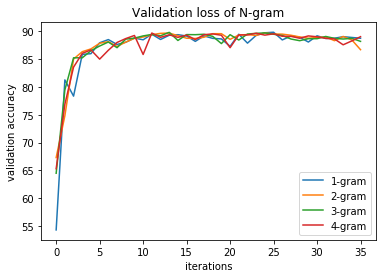

In [57]:
plt.plot(val_acc_list_1, label = '1-gram')
plt.plot(val_acc_list_2, label = '2-gram')  
plt.plot(val_acc_list_3, label = '3-gram')
plt.plot(val_acc_list_4, label = '4-gram')
    
plt.xlabel('iterations')
plt.ylabel('validation accuracy')
plt.title('Validation loss of N-gram')
plt.legend()
plt.show()

In [59]:
loss_list_1 = [float(x) for x in loss_list_1]
loss_list_2 = [float(x) for x in loss_list_2]
loss_list_3 = [float(x) for x in loss_list_3]
loss_list_4 = [float(x) for x in loss_list_4]

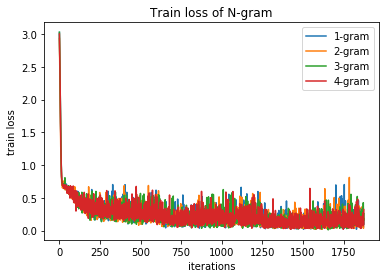

In [60]:
plt.plot(loss_list_1, label = '1-gram')
plt.plot(loss_list_2, label = '2-gram')
plt.plot(loss_list_3, label = '3-gram')
plt.plot(loss_list_4, label = '4-gram')

plt.xlabel('iterations')
plt.ylabel('train loss')
plt.title('Train loss of N-gram')
plt.legend()
plt.show()

# Sample analysis

In [47]:
def generate_samples(loader, model):
    correct_sample = []
    incorrect_sample = []
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        for i, prediction in enumerate(predicted):
            if prediction == label_batch[i]:
                correct_sample.append([val_data[i], val_targets[i], prediction])
            else:
                incorrect_sample.append([val_data[i], val_targets[i], prediction])
        break
    return correct_sample, incorrect_sample

In [48]:
correct_predictions, incorrect_predictions = generate_samples(val_loader, model)

In [49]:
random.sample(correct_predictions, 3)

[["About two hundred members of a Cleveland Ohio USA film society named Cinematheque gathered on August 19 2000 to view a pristine Cinemascope print of Michelangelo Antonioni's 1970 film Zabriskie Point Cinematheque Director John Ewing who does a superlative job of obtaining the finest prints for his series shared with the audience beforehand that this print was specially flown over from Italy for this one showing only  The audience was held spellbound as the film unfolded its artisty on the huge panoramic screen Watching this superb print shown the way Antonioni intended made one aware that this is indeed a modern art work It was all the more fitting that the series is housed in the Cleveland Insititue of Art in University Circle   Antonioni's compositions are created for the Cinemascope landscape His beautiful balancing of images striking use of colors sweeping choreographic movements all are the work of a genuine artist using the screen as his canvas   At last the audience could und

In [51]:
random.sample(incorrect_predictions, 3)

[['Come on people This movie is better than 4 I can see this happeningwealthy people have done crazier things than this And it was funny  I watch a comedy to be entertained escape from the pressures of the world for a short while and not to have to take anything too seriously This movie fully suits that purpose I judge a movie on its own merits and am not about to compare Surviving Christmas to Blazing Saddles I watched totally dysfunctional people grow into caring likable individuals who could easily live down the street from my home It will remain on my list of favoritemust watch for the holiday season If you just want to have a fun 90 minutes watch this one',
  1,
  tensor([0])],
 ["Twisted Desire 1996 was a TV movie starring Melissa Joan Hart Melissa's character Jennifer Stanton a seventeenyearold seduces her current boyfriend Nick Ryan into murdering her two parents The movie is based on the 1990 murders of the parents of 14 year old Jessica Wiseman Jessica had her 17 year old boy